<font color='blue'> **03_Tacho_watershed** </font> 

In [1]:
import pathlib as pl ; import flopy   ; import matplotlib.pyplot as plt ; import numpy as np ; from flopy.discretization import StructuredGrid ; import os
from typing import List, Tuple, Union ; from pathlib import Path ; import pickle ; import pandas as pd ; from flopy.utils.gridintersect import GridIntersect ; 
from shapely.geometry import LineString, Polygon ; import warnings ; warnings.filterwarnings("ignore", category=DeprecationWarning); from pandas import *
sim_ws = Path("./02_tacho_watershed") ;sim_ws.mkdir(exist_ok=True)   ; import rasterio as rio ; import time
import earthpy.spatial as es ; import geopandas as gpd ; import rioxarray as rxr ;  from rasterio.plot import plotting_extent ; import earthpy.plot as ep


c:\Users\gross.DESKTOP-AIRQM2M\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\gross.DESKTOP-AIRQM2M\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\gross.DESKTOP-AIRQM2M\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


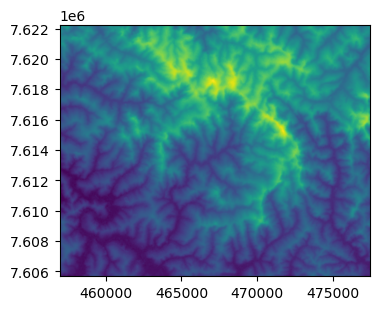

810.0 1243.0


In [2]:
ref_data = Path('E:\\15_REPOS\\a07_EarthPy\\Tacho_02')  
fine_topo = flopy.utils.Raster.load(ref_data / "a00_Tacho_raster.tif")         #ascii_file = pl("E:/15_REPOS/00_BETAMI/bin/Flopy_data/fine_topo.asc") 
fig = plt.figure(figsize=(4,4)) ; ax = fig.add_subplot() ; fine_topo.plot(ax=ax)    ; plt.show(block=False)  ; 
arr = fine_topo.get_array(1)       ; idx = np.isfinite(arr)  ; vmin, vmax = arr[idx].min(), arr[idx].max()   ; print(vmin, vmax)  ;cur_crs=fine_topo.crs

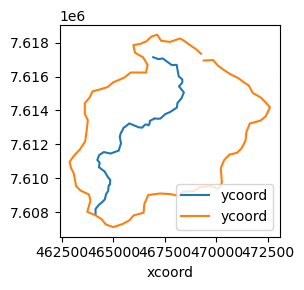

In [3]:
ref_data2 = os.path.join(ref_data ,'s03.xlsx')                                  ; xls = ExcelFile(ref_data2) ; df = xls.parse(xls.sheet_names[0]) ; df.head(2)  
ref_data2 = os.path.join(ref_data ,'00a.xlsx')                                  ; xls = ExcelFile(ref_data2) ; dg = xls.parse(xls.sheet_names[0]) ; dg.head(2)  
df['ab'] = df['xcoord'].astype(str) + ' ' + df['ycoord'].astype(str)            ; dg['ab'] = dg['xcoord'].astype(str) + ' ' + dg['ycoord'].astype(str)   
plt.rcParams["figure.figsize"]=[3,3] ;plt.rcParams["figure.autolayout"] = True  

ax = df.plot(x='xcoord', y='ycoord') ; dg.plot(ax=ax, x='xcoord', y='ycoord') 
xa = pd.to_numeric(dg['xcoord'], errors='coerce', downcast='integer')           ; ya = pd.to_numeric(dg['ycoord'], errors='coerce', downcast='integer')
xa2 = xa.to_frame(); ya2 = ya.to_frame() ; df = pd.concat([xa2[:], ya2[:]], axis=1)  

<font color='red'> **GIS** </font> 

In [4]:
SHP = gpd.read_file(os.path.join(ref_data / '06_bacia_vetor.shp'  ))                   ; uTm = SHP.to_crs(es.crs_check(ref_data / "a00_Tacho_raster.tif" )) 
TIF = rxr.open_rasterio         (ref_data / "a00_Tacho_raster.tif", masked=True)       ; A_extent = plotting_extent(TIF[0], TIF.rio.transform())
#f, ax = plt.subplots(figsize=(4, 4))
#ep.plot_rgb(TIF.values,rgb=[0],ax=ax,title="Over _ naquelas",extent=A_extent)  ; uTm.boundary.plot(ax=ax, color='red') ; plt.show()
TIF2      = rxr.open_rasterio(ref_data / "a00_Tacho_raster.tif", masked=True).rio.clip(uTm.geometry)
B_clip_extent = plotting_extent(TIF2[0], TIF2.rio.transform())               ; print(cur_crs)
#f, ax = plt.subplots()  ; uTm.boundary.plot(ax=ax) ; plt.show() 

EPSG:32723


In [5]:
SHP = gpd.read_file(os.path.join(ref_data / 's01.shp'  ))                   ; uTm_s1 = SHP.to_crs(es.crs_check(ref_data / "a00_Tacho_raster.tif" )) 
TIF = rxr.open_rasterio         (ref_data / "a00_Tacho_raster.tif", masked=True)       ; A_extent = plotting_extent(TIF[0], TIF.rio.transform())
TIF2      = rxr.open_rasterio(ref_data / "a00_Tacho_raster.tif", masked=True).rio.clip(uTm_s1.geometry)
B_clip_extent = plotting_extent(TIF2[0], TIF2.rio.transform())            

<font color='blue'> **MODFLOW** </font> 

In [6]:
Lx=Ly= 12000 ; dx=dy=125.0                   ; nrow=int(Ly/dy)+1  ;ncol=int(Lx/dx)+1              ; un = "meters"
nlay = 1  ; dv0 = 5.0   ; leakance = 1.0 / (0.5 * dv0)   ; idomain = np.ones((nlay , nrow , ncol ), dtype=int)   ; epsg = 32723  
top=np.ones((nlay,nrow,ncol),dtype=float);botm=np.zeros((nlay,nrow,ncol),dtype=float)             ; xoff = B_clip_extent[0] -1000 ;  yoff = B_clip_extent[2]-400

In [7]:
sim = flopy.mf6.MFSimulation (sim_ws=sim_ws ,exe_name="mf6" ,memory_print_option="summary" ,)
flopy.mf6.ModflowTdis (sim)
flopy.mf6.ModflowIms  (sim,complexity="simple" ,print_option="SUMMARY" ,csv_outer_output_filerecord="outer.csv" ,
                            csv_inner_output_filerecord="inner.csv" ,linear_acceleration="bicgstab" ,outer_maximum=1000 ,inner_maximum=100 ,
                            outer_dvclose=1e-4 ,inner_dvclose=1e-5 ,preconditioner_levels=2 ,relaxation_factor=0.0)
gwf = flopy.mf6.ModflowGwf (sim , print_input=True ,save_flows=True ,newtonoptions="NEWTON UNDER_RELAXATION")
flopy.mf6.ModflowGwfdis    (gwf ,length_units=un, nlay=nlay ,nrow=nrow ,ncol=ncol ,delr=dx ,delc=dy ,idomain=idomain ,top=top ,botm=botm 
                            ,xorigin=xoff ,yorigin=yoff)    ; gwf.modelgrid.epsg = epsg   ; print('DIS(gwf.modelgrid): ', gwf.modelgrid )

DIS(gwf.modelgrid):  xll:463122.2813; yll:7607467.75; rotation:0.0; crs:EPSG:32723; units:meters; lenuni:2


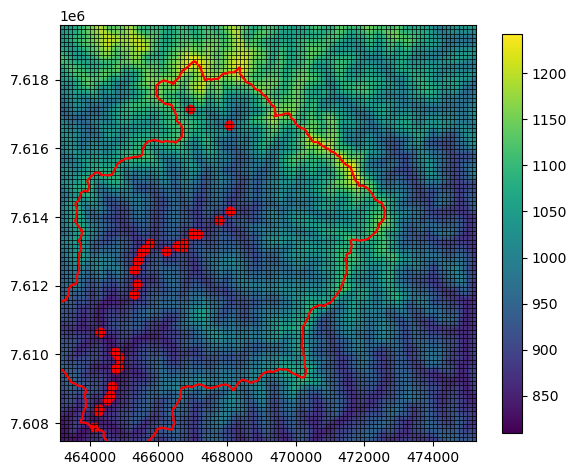

In [8]:
fig = plt.figure(figsize=(6, 6))  ; ax = fig.add_subplot(111) ; ax = fine_topo.plot(ax=ax, vmin=vmin, vmax=vmax)    ;plt.colorbar(ax.images[0], shrink=0.7)  
pmv = flopy.plot.PlotMapView (modelgrid=gwf.modelgrid)        ; pmv.plot_grid(ax=ax, lw=0.5, color="black") 
uTm.boundary.plot(ax=ax, color='red') ;uTm_s1.boundary.plot(ax=ax, color='red') ; plt.show()

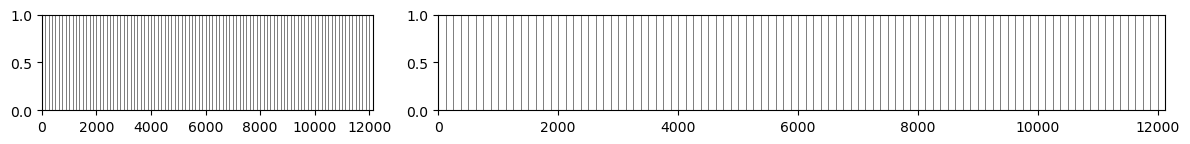

In [9]:
irow, icol = gwf.modelgrid.intersect(xoff+3200, yoff+2900)  
def beta_plot(ax):
    pmv=flopy.plot.PlotCrossSection(model=gwf,ax=ax2, line={"column": icol}) ; pmv.plot_grid(linewidth=0.5) ; pmv.plot_inactive()
    pmv=flopy.plot.PlotCrossSection(model=gwf,ax=ax1, line={"row"   : irow}) ; pmv.plot_grid(linewidth=0.5) ; pmv.plot_inactive()
plt.figure(figsize=(12,4))
ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1, rowspan=1)  ; ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=2, rowspan=1)  ; beta_plot(ax1) ; beta_plot(ax2) 

In [15]:
boundary_polygon = uTm['geometry'].iloc[0]             # ; boundary_polygon # print('DIS(gwf.modelgrid_simple): ', gwf.modelgrid )
stream_segs = uTm_s1['geometry'].iloc[0]               ; uTm_s1.head(5)

,fid,cat,stream_typ,type_code,network,geometry
0,220.0,10,start,0,22,"LINESTRING (466928.531 7617136.5, 467178.531 7..."
1,222.0,39,intermediate,1,22,"LINESTRING (468066.031 7616686.5, 468166.031 7..."
2,230.0,122,intermediate,1,22,"LINESTRING (468078.531 7614174, 467753.531 761..."
3,234.0,123,intermediate,1,22,"LINESTRING (467753.531 7613911.5, 467516.031 7..."
4,235.0,127,intermediate,1,22,"LINESTRING (467166.031 7613511.5, 466978.531 7..."


In [11]:
def set_structured_idomain( modelgrid: flopy.discretization.StructuredGrid,   boundary: List[tuple] ) -> None:

    ix = GridIntersect(modelgrid, method="vertex", rtree=True)     ; result = ix.intersect(Polygon(boundary))
    idx = [coords for coords in result.cellids]                    ; idx = np.array(idx, dtype=int)               ; nr = idx.shape[0]
    if idx.ndim == 1:
        idx = idx.reshape((nr, 1))
    idx = tuple([idx[:, i] for i in range(idx.shape[1])])          ; idomain = np.zeros(modelgrid.shape[1:], dtype=int)
    idomain[idx] = 1 ; idomain = idomain.reshape(modelgrid.shape)  ;     modelgrid.idomain = idomain
    return
working_grid     = StructuredGrid(nlay=nlay,delr=np.full(ncol, dx) , delc=np.full(nrow, dy),
                                  xoff=xoff,yoff=yoff,top=np.full((nrow, ncol), 1000.0),botm=np.full((1, nrow, ncol), -100.0), crs = epsg)
set_structured_idomain(working_grid, boundary_polygon)

In [12]:
top_wg  = fine_topo.resample_to_grid(working_grid,band=fine_topo.bands[0],method="linear",extrapolate_edges=True)
def intersect_segments(modelgrid: Union[flopy.discretization.StructuredGrid, 
                                        flopy.discretization.VertexGrid],segments: List[List[tuple]]) -> Tuple[flopy.utils.GridIntersect, list, list]:
    
    ixs = flopy.utils.GridIntersect(modelgrid,method=modelgrid.grid_type)  ; cellids = []  ; lengths = []
    for sg in segments:
        v = ixs.intersect(LineString(sg), sort_by_cellid=True) ; cellids += v["cellids"].tolist()  ; lengths += v["lengths"].tolist()
    return ixs, cellids, lengths

In [ ]:
def string2geom(geostring: str,conversion: float = None,) -> List[tuple]:
    if conversion is None:         multiplier = 1.0
    else:         multiplier = float(conversion)
    res = []
    for line in geostring.split("\n"):
        line = line.split(" ") ;         x = float(line[0]) * multiplier ; y = float(line[1]) * multiplier ;         res.append((x, y))
    return res
stream_segs  = uTm_s1['geometry'].iloc[0]               # ; stream_segs.head(2)
#stream_segs = (geometry["streamseg1"],geometry["streamseg2"],geometry["streamseg3"],geometry["streamseg4"])  
sgs         = [string2geom(sg) for sg in stream_segs]

ixs, cellids, lengths = intersect_segments(working_grid, sgs)  ; intersection_rg = np.zeros(working_grid.shape[1:])
#for loc in cellids:     intersection_rg[loc] = 1
#fig = plt.figure(figsize=(5,5))     ; ax = fig.add_subplot()   ; pmv = flopy.plot.PlotMapView(modelgrid = working_grid)
#ax.set_aspect("equal")              ; pmv.plot_array(top_wg)   ; pmv.plot_array(intersection_rg,masked_values=[0,],alpha=0.2,cmap="Reds_r")
#pmv.plot_inactive(color_noflow="white") ; ax.plot(bp[:, 0], bp[:, 1], "r-")   # ; plt.colorbar(??, fig)
#for sg in sgs:
#    sa = np.array(sg)  ; ax.plot(sa[:, 0], sa[:, 1], "b-")
#plt.show(block=False)

In [ ]:
def build_drain_data(modelgrid: Union[flopy.discretization.StructuredGrid, flopy.discretization.VertexGrid],cellids: list,
                     lengths: list,leakance: float,elevation: np.ndarray,) -> List[tuple]:
    drn_data = []
    for cellid, length in zip(cellids, lengths):
        x = modelgrid.xcellcenters[cellid]    ; width = 5.0 + (14.0 / Lx) * (Lx - x)  ; conductance = leakance * length * width
        if not isinstance(cellid, tuple):
            cellid = (cellid,)
        drn_data.append((0, *cellid, elevation[cellid], conductance))
    return drn_data
nlay = 5 ; dv0 = 5.0
leakance = 1.0 / (0.5 * dv0)  ; drn_data = build_drain_data(working_grid,cellids,lengths,leakance,top_wg)  #; drn_data[:10]

In [17]:
def cell_areas(modelgrid: Union[flopy.discretization.StructuredGrid, flopy.discretization.VertexGrid]) -> np.ndarray:
    if modelgrid.grid_type == "structured":
        nrow, ncol = modelgrid.nrow, modelgrid.ncol ; areas = np.zeros((nrow, ncol), dtype=float)
        for r in range(nrow):
            for c in range(ncol): 
                cellid = (r, c) ; vertices = np.array(modelgrid.get_cell_vertices(cellid)) ; area = Polygon(vertices).area ; areas[cellid] = area
    elif modelgrid.grid_type == "vertex": 
        areas = np.zeros(modelgrid.ncpl, dtype=float)
        for idx in range(modelgrid.ncpl): 
            vertices = np.array(modelgrid.get_cell_vertices(idx))  ; area = Polygon(vertices).area ; areas[idx] = area
    else:   raise ValueError(+ f"{modelgrid.grid_type}")
    return areas

In [18]:
def build_groundwater_discharge_data(modelgrid: Union[flopy.discretization.StructuredGrid, flopy.discretization.VertexGrid],
                                     leakance: float,elevation: np.ndarray,) -> List[tuple]:
    areas = cell_areas(modelgrid)   ; drn_data = [] ; idomain = modelgrid.idomain[0]
    for idx in range(modelgrid.ncpl):
        if modelgrid.grid_type == "structured":  r, c = modelgrid.get_lrc(idx)[0][1:]  ; cellid = (r, c)
        else:                                    cellid = idx 
        area = areas[cellid]
        if idomain[cellid] == 1:
            conductance = leakance * area
            if not isinstance(cellid, tuple):    cellid = (cellid,)
            drn_data.append((0, *cellid, elevation[cellid] - 0.5, conductance, 1.0))
    return drn_data
gw_discharge_data = build_groundwater_discharge_data(working_grid,leakance,top_wg)  # gw_discharge_data[:10]

In [19]:
idomain = np.array([working_grid.idomain[0, :, :].copy() for k in range(nlay)])
strt    = np.array([top_wg.copy() for k in range(nlay)], dtype=float)
topc = np.zeros((nlay, nrow, ncol), dtype=float)         ; botm = np.zeros((nlay, nrow, ncol), dtype=float)
dv = dv0 ; topc[0] = top_wg.copy()                       ; botm[0] = topc[0] - dv
for idx in range(1, nlay):  dv *= 1.5                    ; topc[idx] = botm[idx - 1]    ; botm[idx] = topc[idx] - dv
for k in range(nlay): print((topc[k] - botm[k]).mean())

5.0
7.5
11.25
16.875
25.3125


In [20]:
sim = flopy.mf6.MFSimulation(sim_ws=sim_ws,exe_name="mf6",memory_print_option="summary",)

flopy.mf6.ModflowTdis(sim)
flopy.mf6.ModflowIms(sim,complexity="simple",print_option="SUMMARY",csv_outer_output_filerecord="outer.csv",
                           csv_inner_output_filerecord="inner.csv",linear_acceleration="bicgstab",outer_maximum=1000,inner_maximum=100,
                           outer_dvclose=1e-4,inner_dvclose=1e-5,preconditioner_levels=2,relaxation_factor=0.0)
gwf = flopy.mf6.ModflowGwf(sim,print_input=True,save_flows=True,newtonoptions="NEWTON UNDER_RELAXATION")
flopy.mf6.ModflowGwfdis(gwf,nlay=nlay,nrow=nrow,ncol=ncol,delr=dx,delc=dy,idomain=idomain,top=top_wg,botm=botm,xorigin=0.0,yorigin=0.0)
flopy.mf6.ModflowGwfic(gwf, strt=strt)
flopy.mf6.ModflowGwfnpf(gwf,save_specific_discharge=True,icelltype=1,k=1.0)
flopy.mf6.ModflowGwfrcha(gwf,recharge=0.000001)
#flopy.mf6.ModflowGwfdrn(gwf,maxbound=len(drn_data),stress_period_data=drn_data,pname="river",filename="drn_riv.drn")
#flopy.mf6.ModflowGwfdrn(gwf,auxiliary=["depth"],auxdepthname="depth",maxbound=len(gw_discharge_data),
#                                  stress_period_data=gw_discharge_data,pname="gwd",filename="drn_gwd.drn")
flopy.mf6.ModflowGwfoc(gwf,head_filerecord=f"{gwf.name}.hds",budget_filerecord=f"{gwf.name}.cbc",
                            saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],printrecord=[("BUDGET", "ALL")]) ; 

In [21]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model model...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package oc...


In [22]:
def get_model_cell_count(model: Union[flopy.mf6.ModflowGwf,flopy.mf6.ModflowGwt]) -> Tuple[int, int]:
    modelgrid = model.modelgrid
    if modelgrid.grid_type == "structured":
        nlay, nrow, ncol = modelgrid.nlay, modelgrid.nrow, modelgrid.ncol ; ncells = nlay * nrow * ncol ; idomain = modelgrid.idomain
        if idomain is None:             nactive = nlay * nrow * ncol
        else:                           nactive = np.count_nonzero(idomain == 1)
    elif modelgrid.grid_type == "vertex":
        nlay, ncpl = modelgrid.nlay, modelgrid.ncpl ; ncells = nlay * ncpl ;         idomain = modelgrid.idomain
        if idomain is None:             nactive = nlay * ncpl
        else:                           nactive = np.count_nonzero(idomain == 1)
    else:         raise ValueError(f"modelgrid grid type '{modelgrid.grid_type}' not supported")
    return ncells, nactive
def get_simulation_cell_count(simulation: flopy.mf6.MFSimulation,) -> Tuple[int, int]:
    ncells = 0 ;     nactive = 0
    for model_name in simulation.model_names:
        model = simulation.get_model(model_name) ; i, j = get_model_cell_count(model) ; ncells += i ; nactive += j
    return ncells, nactive
ncells, nactive = get_simulation_cell_count(sim) ;  print("nr. of cells:", ncells, ", active:", nactive)

nr. of cells: 47045 , active: 21060
